# PROJEK AKHIR KECERDASAN BUATAN
## Pendeteksi Keretakan pada Bangunan
Projek membahas mengenai model Kecerdasan Buatan dalam mendeteksi keretakan pada bangunan. <br>
Sumber dataset: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection

## Kelompok 4
AZIIZAH OKI SHOFRINA (2109106004) - <b> Ketua </b> <br> 
Jobdesk: Data Collecting (spliting data), Data Preprocessing, Modelling, Evaluasi <br>

ALIYA IRFANI         (2109106007) <br>
Jobdesk: Data Collecting (visualisasi), Modelling, Evaluasi <br>

CHINTIA LIU WINTIN   (2109106008) <br>
Jobdesk: Data Collecting (metadata), Modelling, Evaluasi <br>

# Table of Contents

1. [Data Collecting](#1.-Data-Collecting) <br>
    A. [Training Set](#A.-Training-Set) <br> 
    B. [Validation Set](#B.-Validation-Set) <br>
    C. [Testing Set](#C.-Testing-Set) <br>
    
2. [Data Preprocessing, Data Analisis, dan, Visualisasi](#2.-Data-Preprocessing,-Data-Analisis,-dan-Visualisasi) <br>
    A. [Brightness](#A.-Brightness) <br>
    B. [Hue](#B.-Hue) <br>
    C. [Saturation](#C.-Saturation) <br>
    D. [Grayscale](#D.-Grayscale) <br>
    E. [Contrast](#E.-Contrast) <br>
    F. [Normalisasi](#F.-Normalisasi) <br>
    G. [Standardisasi](#G.-Standardisasi) <br>
    
3. [Data Modelling dan Evaluasi](#3.-Data-Modelling-dan-Evaluasi) <br>
    A. [Model Normalisasi RGB](#A.-Model-Normalisasi-RGB) <br>
    B. [Model Standardisasi RGB](#B.-Model-Standardisasi-RGB) <br>
    C. [Model Normalisasi Grayscale](#C.-Model-Normalisasi-Grayscale) <br>
    D. [Model Standardisasi Grayscale](#D.-Model-Standardisasi-Grayscale) <br>
    
4. [Kesimpulan](#4.-Kesimpulan)
5. [Save Model](#5.-Save-Model)

## Import Modul

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Data Collecting

## A. Training Set

In [2]:
train_set = image_dataset_from_directory(
    "dataset/train",
    labels="inferred",
    label_mode="binary",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    subset="training",
    validation_split=0.1,
    batch_size=128
)

Found 36000 files belonging to 2 classes.
Using 32400 files for training.


## B. Validation Set

In [3]:
val_set = image_dataset_from_directory(
    "dataset/train",
    labels="inferred",
    label_mode="binary",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    subset="validation",
    validation_split=0.1,
    batch_size=128
)

Found 36000 files belonging to 2 classes.
Using 3600 files for validation.


## C. Testing Set

In [4]:
test_set = image_dataset_from_directory(
    "dataset/test",
    labels="inferred",
    label_mode="binary",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=False,
    batch_size=128
)

Found 4000 files belonging to 2 classes.


### Kelas yang Digunakan

In [5]:
classes = train_set.class_names
classes

['Negative', 'Positive']

### Shape Gambar dan Label

In [6]:
for images, labels in train_set.take(1):
    print(images.shape)
    print(labels.shape)
    break

(128, 64, 64, 3)
(128, 1)


## Preview Gambar

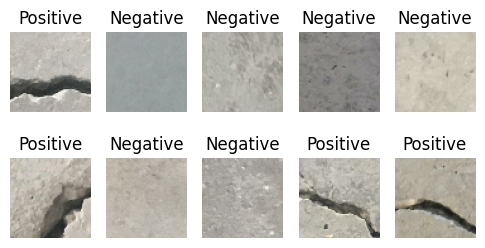

In [7]:
def preview_imgs(dataset):
    plt.figure(figsize=(6, 3))

    # ambil 1 batch
    for images, labels in dataset.take(1):
        
        # ambil 9 gambar
        for i in range(10):
            plt.subplot(2, 5, i+1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
            plt.title("Negative" if labels[i].numpy()== 0 else "Positive")
            plt.axis("off")
            
preview_imgs(train_set)

## Sample Gambar

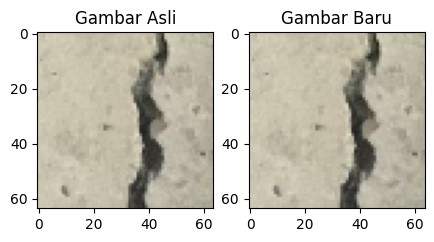

In [8]:
def sample_img(image1, image2):
    plt.figure(figsize=(5, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Gambar Asli")
    plt.imshow(image1.numpy().astype("uint8"), cmap="gray")
    
    plt.subplot(1, 2, 2)
    plt.title("Gambar Baru")
    plt.imshow(image2.numpy().astype("uint8"), cmap="gray")

# ambil 1 contoh gambar
for images, labels in train_set.take(1):
    ori_img = images[49]

sample_img(ori_img, ori_img)

# 2. Data Preprocessing, Data Analisis, dan Visualisasi

## A. Brightness
Sesuaikan kecerahan gambar

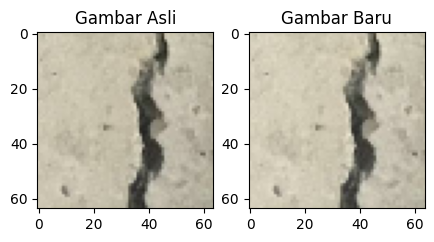

In [9]:
sample_img(ori_img, tf.image.random_brightness(ori_img, max_delta=10, seed=42))

#### Sesuaikan kecerahan dataset gambar

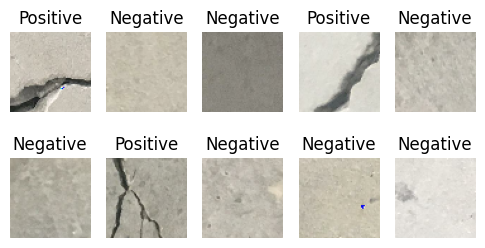

In [10]:
def brightness(x, y):
    image = tf.image.random_brightness(x, max_delta=10, seed=42)
    return image, y

b_train = train_set.map(brightness)
b_val = val_set.map(brightness)
b_test = test_set.map(brightness)

preview_imgs(b_train)

## B. Hue
Memberikan nuansa warna baru pada gambar

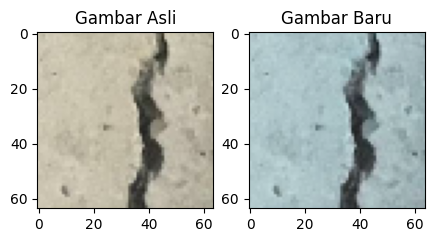

In [11]:
sample_img(ori_img, tf.image.random_hue(ori_img, max_delta=0.5, seed=42))

### Sesuaikan warna dataset gambar

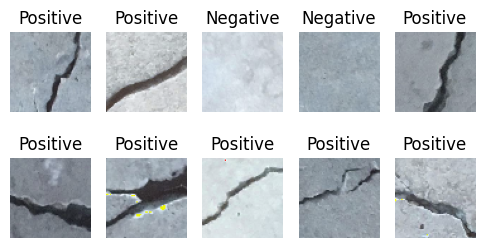

In [12]:
def hue(x, y):
    image = tf.image.random_hue(x, max_delta=0.5, seed=42)
    return image, y
    
hue_train = b_train.map(hue)
hue_val = b_val.map(hue)
hue_test = b_test.map(hue)

preview_imgs(hue_train)

## C. Saturation
Menyesuaikan insensitas warna. Semakin tinggi saturasi, semakin terang

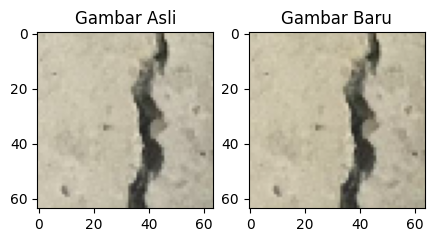

In [13]:
sample_img(ori_img, tf.image.random_saturation(ori_img, 0.5, 1.5, seed=42))

### Sesuaikan saturasi dataset gambar

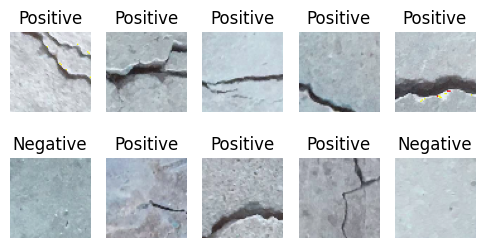

In [14]:
def saturate(x, y):
    image = tf.image.random_saturation(x, 0.5, 1.5, seed=42)
    return image, y
    
s_train = hue_train.map(saturate)
s_val = hue_val.map(saturate)
s_test = hue_test.map(saturate)

preview_imgs(s_train)

## D. Grayscale
Membuat gambar skala abu-abu

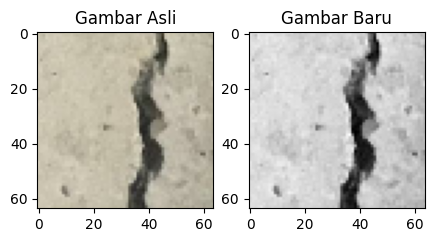

In [15]:
sample_img(ori_img, tf.image.rgb_to_grayscale(ori_img))

### Grayscaling dataset gambar

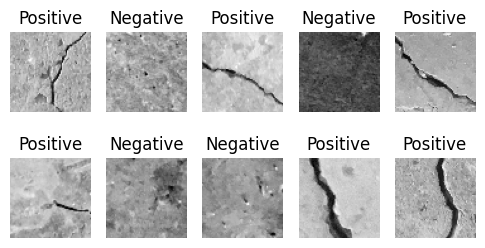

In [16]:
def grayscale(x, y):
    image = tf.image.rgb_to_grayscale(x)
    return image, y

g_train = train_set.map(grayscale)
g_val = val_set.map(grayscale)
g_test = test_set.map(grayscale)

preview_imgs(g_train)

### Shape Gambar Setelah Grayscaling

In [17]:
for image, label in g_train.take(1):
    print(image.numpy().shape)
    break

(128, 64, 64, 1)


## E. Contrast
Meningkatkan perbedaan antara bagian yang lebih cerah dan lebih gelap

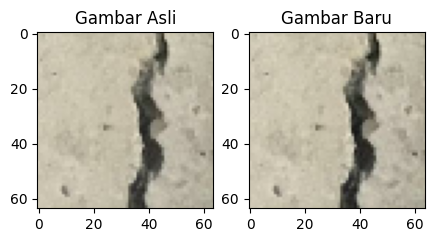

In [18]:
sample_img(ori_img, tf.image.random_contrast(ori_img, 1, 1.5, seed=42))

### Kontraskan dataset gambar RGB

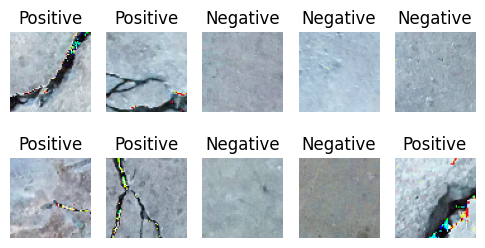

In [19]:
def contrast(x, y):
    image = tf.image.random_contrast(x, 1, 1.5, seed=42)
    return image, y

c_train_rgb = s_train.map(contrast)
c_val_rgb = s_val.map(contrast)
c_test_rgb = s_test.map(contrast)

preview_imgs(c_train_rgb)

### Kontraskan dataset gambar Grayscale

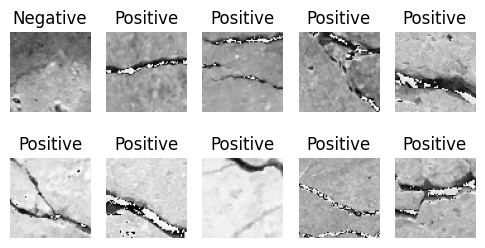

In [20]:
c_train_gray = g_train.map(contrast)
c_val_gray = g_val.map(contrast)
c_test_gray = g_test.map(contrast)

preview_imgs(c_train_gray)

## F. Normalisasi
Rescale gambar menjadi skala dalam rentang [0, 1]

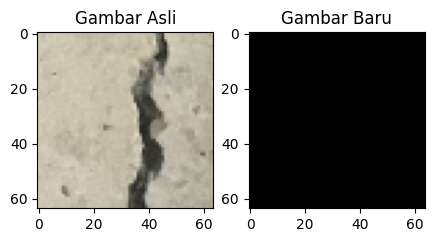

In [21]:
sample_img(ori_img, tf.keras.layers.Rescaling(1./255)(ori_img))

### Normalisasi dataset gambar RGB

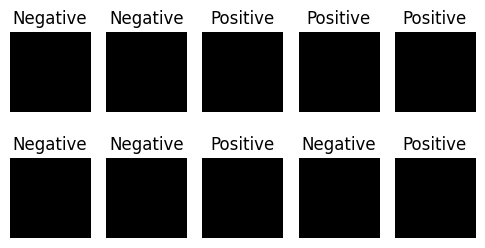

In [22]:
def normalize_img(x, y):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    return normalization_layer(x), y

norm_train_rgb = c_train_rgb.map(normalize_img)
norm_val_rgb = c_val_rgb.map(normalize_img)
norm_test_rgb = c_test_rgb.map(normalize_img)

preview_imgs(norm_train_rgb)

### Normalisasi dataset gambar Grayscale

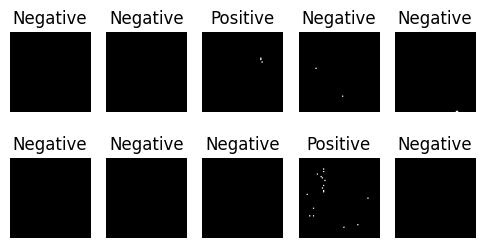

In [23]:
norm_train_gray = c_train_gray.map(normalize_img)
norm_val_gray = c_val_gray.map(normalize_img)
norm_test_gray = c_test_gray.map(normalize_img)

preview_imgs(norm_train_gray)

## G. Standardisasi
Standardisasi gambar sehingga memiliki rata-rata 0 dan varians 1

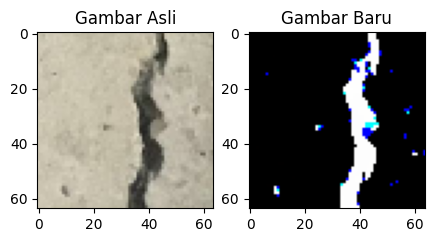

In [24]:
sample_img(ori_img, tf.image.per_image_standardization(ori_img))

### Standardisasi dataset gambar RGB

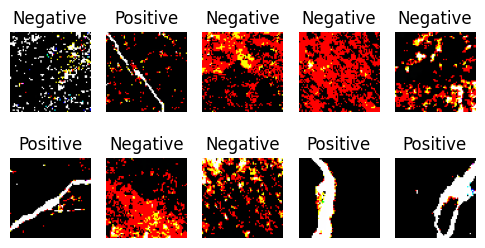

In [25]:
def standardization(x, y):
    image = tf.image.per_image_standardization(x)
    return image, y

std_train_rgb = c_train_rgb.map(standardization)
std_val_rgb = c_val_rgb.map(standardization)
std_test_rgb = c_test_rgb.map(standardization)

preview_imgs(std_train_rgb)

### Standardisasi dataset gambar Grayscale

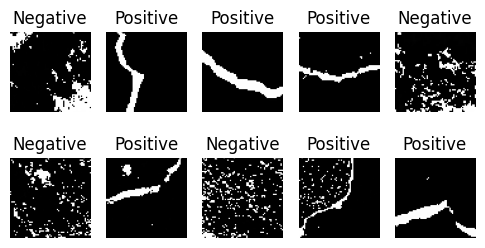

In [26]:
std_train_gray = c_train_gray.map(standardization)
std_val_gray = c_val_gray.map(standardization)
std_test_gray = c_test_gray.map(standardization)

preview_imgs(std_train_gray)

# 3. Data Modelling dan Evaluasi

## A. Model Normalisasi RGB 

In [27]:
model_norm_rgb = Sequential([
    Input((64, 64, 3)),
    
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation="relu"),
    
    Dense(1, activation="sigmoid")
])

model_norm_rgb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 16)         0

In [28]:
model_norm_rgb.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model Normalisasi RGB - Fitting Model

In [29]:
history_norm_rgb = model_norm_rgb.fit(
    norm_train_rgb,
    validation_data=norm_val_rgb,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 107s 416ms/step - loss: 0.1137 - accuracy: 0.9579 - val_loss: 0.0579 - val_accuracy: 0.9822
Epoch 2/10
254/254 [==============================] - 95s 372ms/step - loss: 0.0424 - accuracy: 0.9867 - val_loss: 0.0380 - val_accuracy: 0.9875
Epoch 3/10
254/254 [==============================] - 85s 333ms/step - loss: 0.0358 - accuracy: 0.9881 - val_loss: 0.0355 - val_accuracy: 0.9883
Epoch 4/10
254/254 [==============================] - 87s 341ms/step - loss: 0.0326 - accuracy: 0.9894 - val_loss: 0.0287 - val_accuracy: 0.9903
Epoch 5/10
254/254 [==============================] - 84s 329ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0224 - val_accuracy: 0.9928
Epoch 6/10
254/254 [==============================] - 93s 366ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 0.0173 - val_accuracy: 0.9950
Epoch 7/10
254/254 [==============================] - 86s 338ms/step - loss: 0.0175 - accuracy: 0.9945 - val_loss: 0.0214 - val_a

### Model Normalisasi RGB - Visualisasi Training Validation

In [284]:
def visualisasi_plot(model):
    epoch = [i+1 for i in range(10)]

    sns.set_theme()

    plt.figure(figsize=(11, 4))
    plt.suptitle("Train vs Validation")

    # grafik akurasi
    plt.subplot(1, 2, 1)
    plt.title("Accuracy")
    sns.lineplot(
        x=epoch,
        y=model.history["accuracy"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_accuracy"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy(%)")

    # grafik loss
    plt.subplot(1, 2, 2)
    plt.title("Loss")
    sns.lineplot(
        x=epoch,
        y=model.history["loss"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_loss"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Loss(%)")

    plt.show()

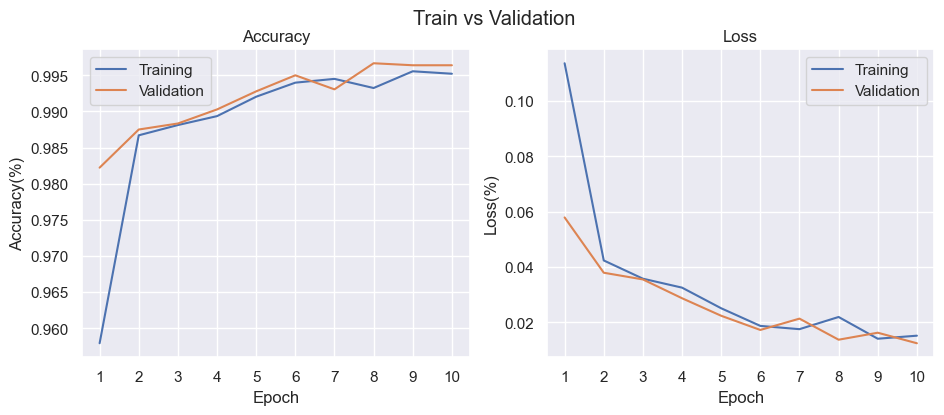

In [285]:
visualisasi_plot(history_norm_rgb)

### Model Normalisasi RGB - Evaluasi Testing

In [276]:
def evaluate_model(test_set, score, hasil_prediksi):
    print(
        f"Test Loss     : {score[0]}\
        \nTest Accuracy : {score[1]*100}%"
    )
    
    # Confusion Matrix
    labels = [label for image, label in test_set.unbatch()]

    cm = confusion_matrix(labels, hasil_prediksi)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Tidak Retak", "Retak"]
    )
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title("Evaluasi Testing")
    plt.grid(False)
    
    plt.show()

In [126]:
score_norm_rgb = model_norm_rgb.evaluate(norm_test_rgb)
prediksi_norm_rgb = (model_norm_rgb.predict(norm_test_rgb).squeeze() >= 0.5).astype(int)

32/32 [==============================] - 7s 218ms/step


Test Loss     : 0.007955406792461872        
Test Accuracy : 99.82500076293945%


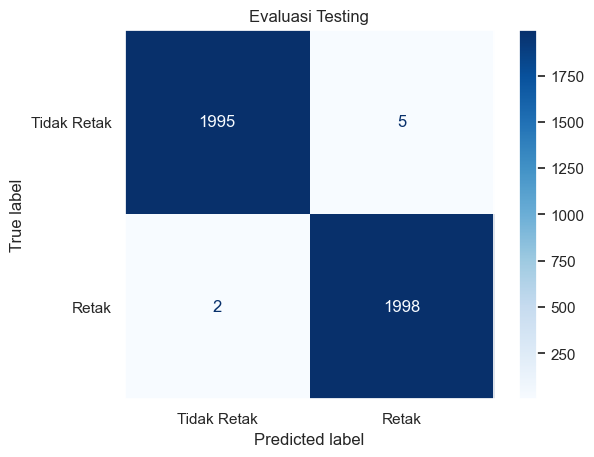

In [277]:
evaluate_model(norm_test_rgb, score_norm_rgb, prediksi_norm_rgb)

### Model Normalisasi RGB - Prediksi Test Set

In [35]:
def show_prediction(test_set, hasil_prediksi, mode=None):

    images = []
    labels = []
    labels_pred = []

    i = 0
    # simpan ke list
    for image, label in test_set.unbatch():
        
        if (mode == "normalize"):
            images.append((image.numpy()*255).astype("uint8"))
        else:
            images.append((image.numpy()).astype("uint8"))
            
        labels.append("Tidak Retak" if label == 0 else "Retak")
        labels_pred.append("Tidak Retak" if hasil_prediksi[i] == 0 else "Retak")
        i += 1

    plt.figure(figsize=(12, 4))

    # tampilkan 14 gambar prediksi
    for i in range(14):
        plt.subplot(2, 7, i+1)

        # ambil gambar acak
        index = randint(0, len(images))
        plt.imshow(images[index], cmap="gray")

        # label prediksi
        color = "green" if labels_pred[index] == labels[index] else "red"
        plt.title(f"{labels_pred[index]}", color=color)

        plt.axis("off")


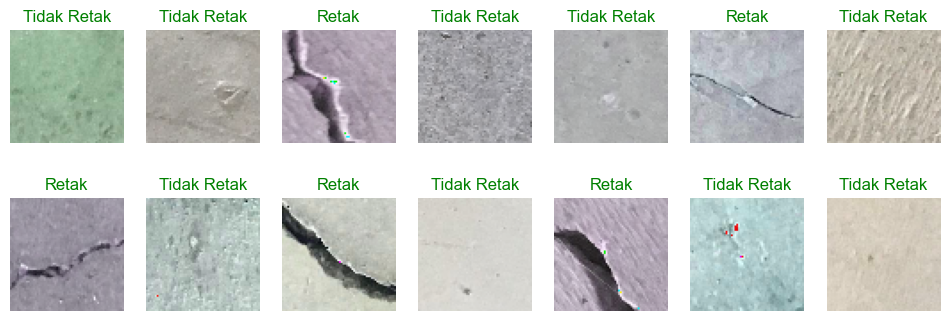

In [36]:
show_prediction(norm_test_rgb, prediksi_norm_rgb, mode="normalize")

### Model Normalisasi RGB - Kesalahan Prediksi Test Set

In [37]:
def show_mistakes(test_set, hasil_prediksi, mode=None):
    images = []
    labels = []
    labels_pred = []
    i=0
    
    for image, label in test_set.unbatch():

        # simpan hasil yang salah
        if (label != hasil_prediksi[i]):
            
            if (mode == "normalize"):
                images.append((image.numpy()*255).astype("uint8"))
            else:
                images.append((image.numpy()).astype("uint8"))
                
            labels.append("Tidak Retak" if label == 0 else "Retak")
            labels_pred.append("Tidak Retak" if hasil_prediksi[i] == 0 else "Retak")
        i+=1

    # tampilkan prediksi yang salah
    plt.figure(figsize=(12, 12))
    i=0
    for i in range(len(images)):
        plt.subplot(7, 7, i+1)
        plt.imshow(images[i], cmap="gray")
        plt.title(labels_pred[i], color="red")
        plt.axis("off")
        
    plt.show()
    

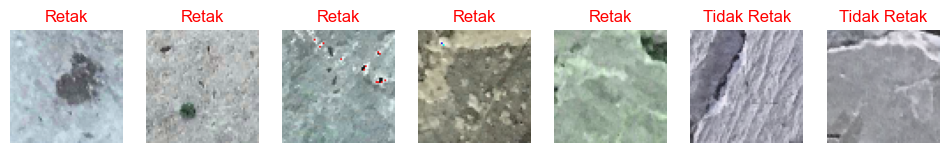

In [38]:
show_mistakes(norm_test_rgb, prediksi_norm_rgb, mode="normalize")

## B. Model Standardisasi RGB

In [39]:
model_std_rgb = Sequential([
    Input((64, 64, 3)),
    
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation="relu"),
    
    Dense(1, activation="sigmoid")
])

model_std_rgb.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 16)        

In [40]:
model_std_rgb.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model Standardisasi RGB - Fitting Model

In [41]:
history_std_rgb = model_std_rgb.fit(
    std_train_rgb,
    validation_data=std_val_rgb,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 95s 369ms/step - loss: 0.0825 - accuracy: 0.9689 - val_loss: 0.0301 - val_accuracy: 0.9900
Epoch 2/10
254/254 [==============================] - 86s 336ms/step - loss: 0.0250 - accuracy: 0.9914 - val_loss: 0.0268 - val_accuracy: 0.9906
Epoch 3/10
254/254 [==============================] - 85s 333ms/step - loss: 0.0170 - accuracy: 0.9943 - val_loss: 0.0129 - val_accuracy: 0.9961
Epoch 4/10
254/254 [==============================] - 85s 335ms/step - loss: 0.0098 - accuracy: 0.9971 - val_loss: 0.0105 - val_accuracy: 0.9964
Epoch 5/10
254/254 [==============================] - 85s 334ms/step - loss: 0.0107 - accuracy: 0.9967 - val_loss: 0.0127 - val_accuracy: 0.9969
Epoch 6/10
254/254 [==============================] - 85s 332ms/step - loss: 0.0107 - accuracy: 0.9965 - val_loss: 0.0228 - val_accuracy: 0.9942
Epoch 7/10
254/254 [==============================] - 85s 334ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.0104 - val_ac

### Model Standardisasi RGB - Visualisasi Training Validation

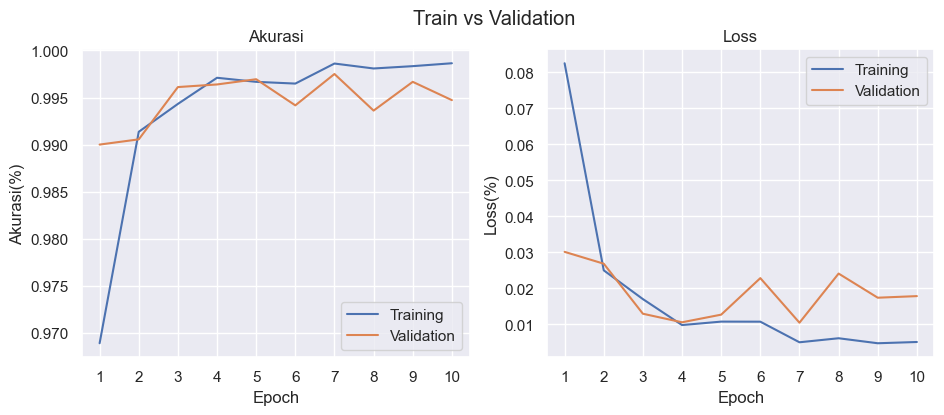

In [278]:
visualisasi_plot(history_std_rgb)

### Model Standardisasi RGB - Evaluasi Testing

In [130]:
score_std_rgb = model_std_rgb.evaluate(std_test_rgb)
prediksi_std_rgb = (model_std_rgb.predict(std_test_rgb).squeeze() >= 0.5).astype(int)

32/32 [==============================] - 7s 208ms/step


Test Loss     : 0.013678083196282387        
Test Accuracy : 99.6500015258789%


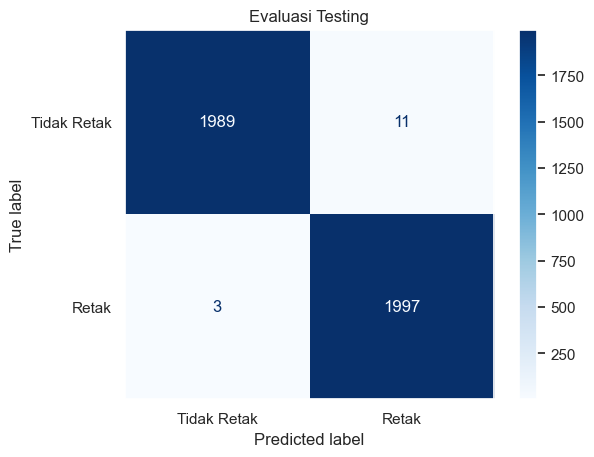

In [131]:
evaluate_model(std_test_rgb, score_std_rgb, prediksi_std_rgb)

### Model Standardisasi RGB - Prediksi Test Set

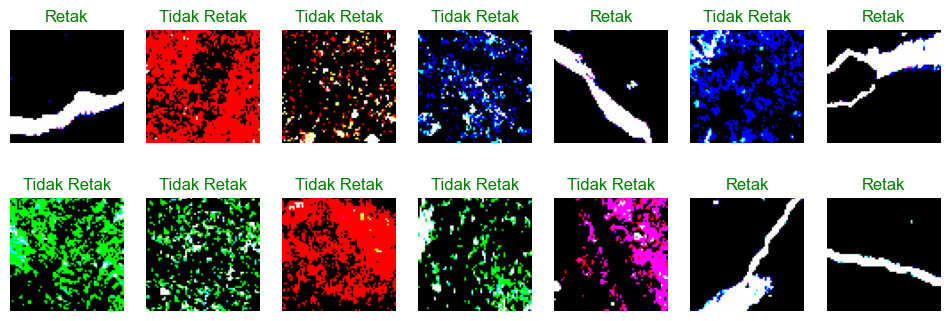

In [45]:
show_prediction(std_test_rgb, prediksi_std_rgb)

### Model Standardisasi RGB - Kesalahan Prediksi Test Set

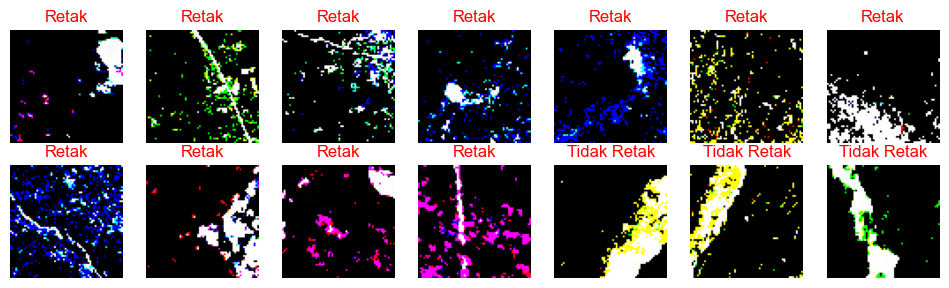

In [46]:
show_mistakes(std_test_rgb, prediksi_std_rgb)

## C. Model Normalisasi Grayscale

In [47]:
model_norm_gray = Sequential([
    Input((64, 64, 1)),
    
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation="relu"),
    
    Dense(1, activation="sigmoid")
])

model_norm_gray.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 16)        

In [48]:
model_norm_gray.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model Normalisasi Grayscale - Fitting Model

In [49]:
history_norm_gray = model_norm_gray.fit(
    norm_train_gray,
    validation_data=norm_val_gray,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 86s 335ms/step - loss: 0.1314 - accuracy: 0.9512 - val_loss: 0.0507 - val_accuracy: 0.9850
Epoch 2/10
254/254 [==============================] - 80s 315ms/step - loss: 0.0480 - accuracy: 0.9851 - val_loss: 0.0427 - val_accuracy: 0.9864
Epoch 3/10
254/254 [==============================] - 81s 315ms/step - loss: 0.0432 - accuracy: 0.9857 - val_loss: 0.0382 - val_accuracy: 0.9869
Epoch 4/10
254/254 [==============================] - 83s 326ms/step - loss: 0.0408 - accuracy: 0.9864 - val_loss: 0.0354 - val_accuracy: 0.9869
Epoch 5/10
254/254 [==============================] - 82s 321ms/step - loss: 0.0339 - accuracy: 0.9883 - val_loss: 0.0287 - val_accuracy: 0.9897
Epoch 6/10
254/254 [==============================] - 83s 324ms/step - loss: 0.0269 - accuracy: 0.9906 - val_loss: 0.0179 - val_accuracy: 0.9936
Epoch 7/10
254/254 [==============================] - 80s 315ms/step - loss: 0.0225 - accuracy: 0.9935 - val_loss: 0.0135 - val_ac

### Model Normalisasi Grayscale - Visualisasi Training Validation

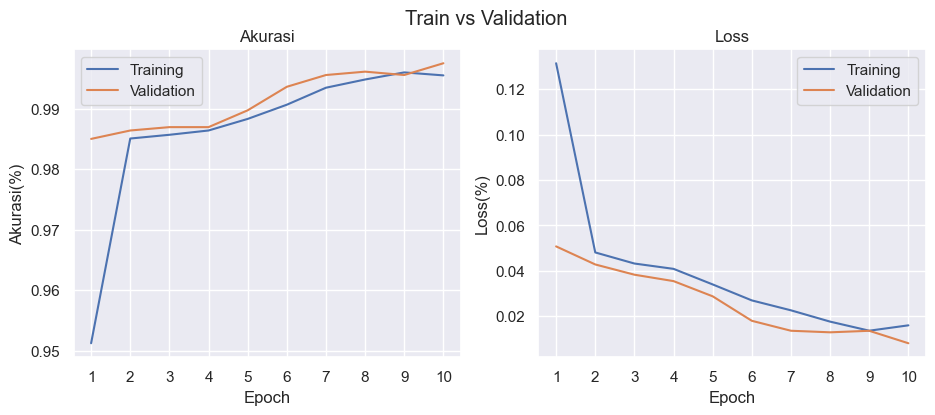

In [279]:
visualisasi_plot(history_norm_gray)

### Model Normalisasi Grayscale - Evaluasi Testing

In [132]:
score_norm_gray = model_norm_gray.evaluate(norm_test_gray)
prediksi_norm_gray = (model_norm_gray.predict(norm_test_gray).squeeze() >= 0.5).astype(int)

32/32 [==============================] - 7s 197ms/step


Test Loss     : 0.008950402960181236        
Test Accuracy : 99.59999918937683%


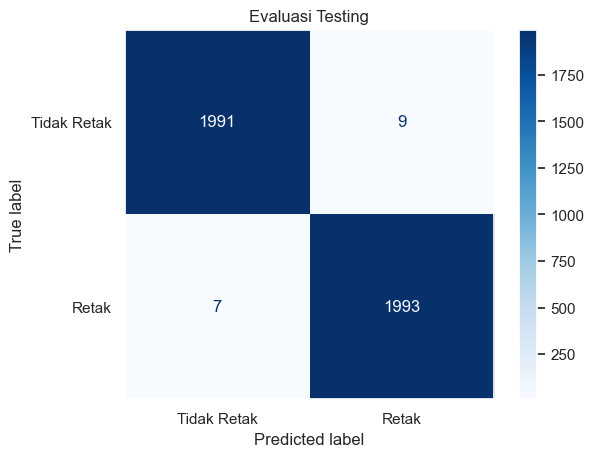

In [133]:
evaluate_model(norm_test_gray, score_norm_gray, prediksi_norm_gray)

### Model Normalisasi Grayscale - Prediksi Test Set

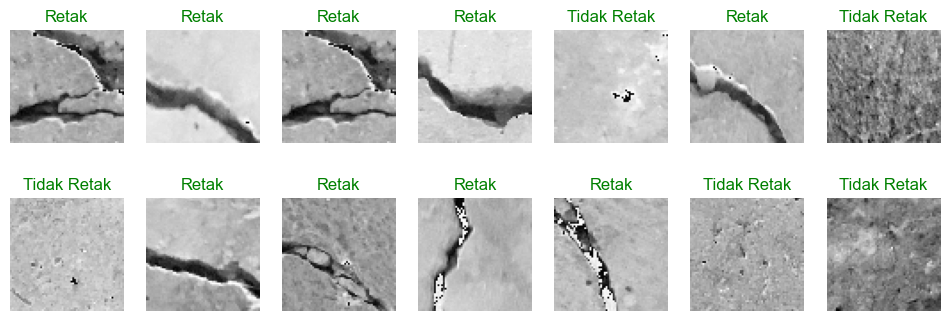

In [53]:
show_prediction(norm_test_gray, prediksi_norm_gray, mode="normalize")

### Model Normalisasi Grayscale - Kesalahan Prediksi Test Set

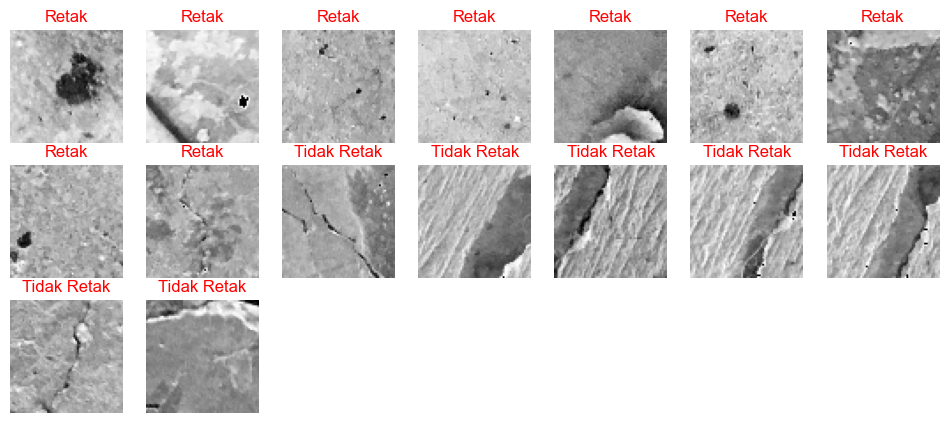

In [54]:
show_mistakes(norm_test_gray, prediksi_norm_gray, mode="normalize")

## D. Model Standardisasi Grayscale

In [55]:
model_std_gray = Sequential([
    Input((64, 64, 1)),
    
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation="relu"),
    
    Dense(1, activation="sigmoid")
])
model_std_gray.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 16)        

In [56]:
model_std_gray.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model Standardisasi Grayscale - Fitting Model

In [57]:
history_std_gray = model_std_gray.fit(
    std_train_gray,
    validation_data = std_val_gray,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 89s 347ms/step - loss: 0.1027 - accuracy: 0.9604 - val_loss: 0.0438 - val_accuracy: 0.9864
Epoch 2/10
254/254 [==============================] - 154s 605ms/step - loss: 0.0352 - accuracy: 0.9881 - val_loss: 0.0217 - val_accuracy: 0.9914
Epoch 3/10
254/254 [==============================] - 171s 669ms/step - loss: 0.0208 - accuracy: 0.9936 - val_loss: 0.0258 - val_accuracy: 0.9928
Epoch 4/10
254/254 [==============================] - 172s 672ms/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 0.0178 - val_accuracy: 0.9936
Epoch 5/10
254/254 [==============================] - 171s 669ms/step - loss: 0.0121 - accuracy: 0.9965 - val_loss: 0.0274 - val_accuracy: 0.9914
Epoch 6/10
254/254 [==============================] - 171s 668ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.0251 - val_accuracy: 0.9925
Epoch 7/10
254/254 [==============================] - 169s 661ms/step - loss: 0.0082 - accuracy: 0.9973 - val_loss: 0.0124 - 

### Model Standardisasi Grayscale - Visualisasi Training Validation

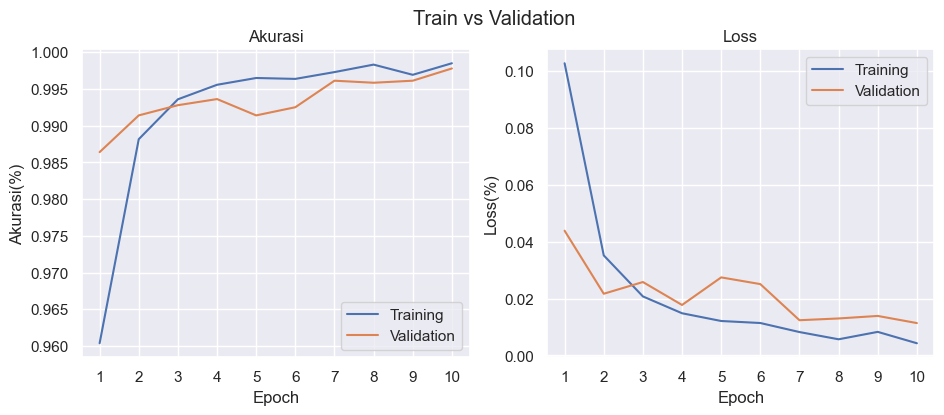

In [280]:
visualisasi_plot(history_std_gray)

### Model  Standardisasi Grayscale - Evaluasi Testing

In [135]:
score_std_gray = model_std_gray.evaluate(std_test_gray)
prediksi_std_gray = (model_std_gray.predict(std_test_gray).squeeze() >= 0.5).astype(int)

32/32 [==============================] - 6s 188ms/step


Test Loss     : 0.01821436546742916        
Test Accuracy : 99.50000047683716%


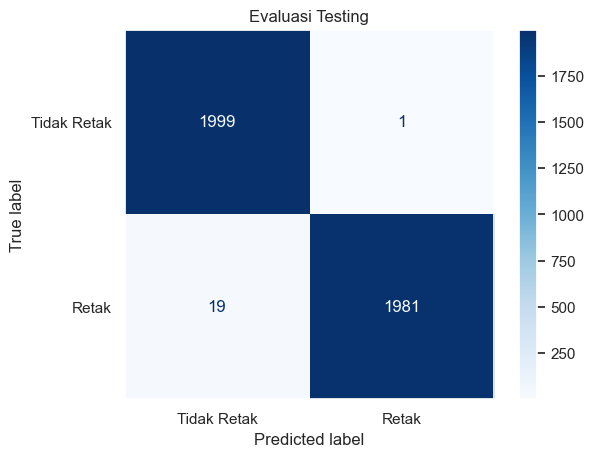

In [136]:
evaluate_model(std_test_gray, score_std_gray, prediksi_std_gray)

### Model Standardisasi Grayscale - Prediksi Test Set

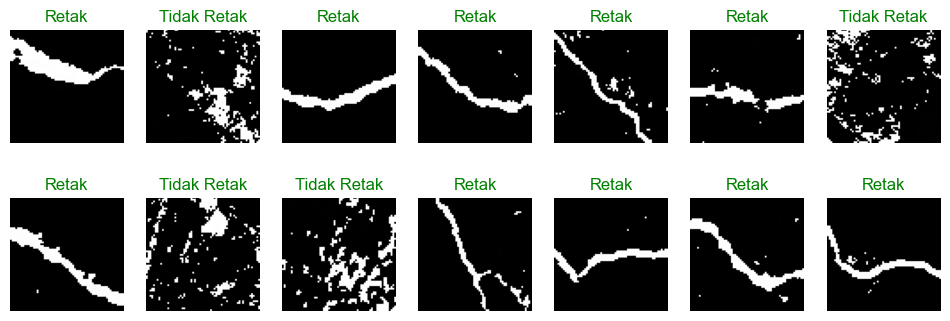

In [61]:
show_prediction(std_test_gray, prediksi_std_gray)

### Model  Standardisasi Grayscale - Kesalahan Prediksi Test Set

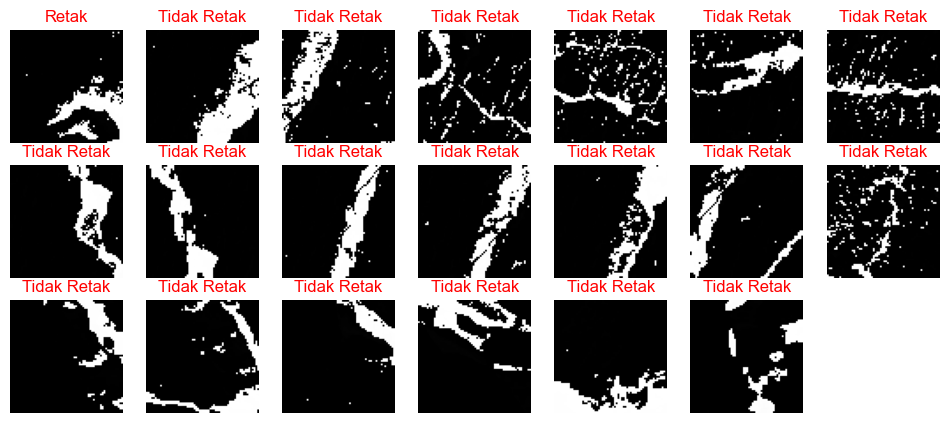

In [62]:
show_mistakes(std_test_gray, prediksi_std_gray)

# 4. Kesimpulan
Setelah dilakukan fitting model dari 4 data training berbeda, yakni
<ul>
    <li> Normalisasi RGB </li>
    <li> Normalisasi Grayscale </li>
    <li> Standardisasi RGB  </li>
    <li> Standardisasi Grayscale </li>
</ul>

Didapatkan hasil evaluasi sebagai berikut.

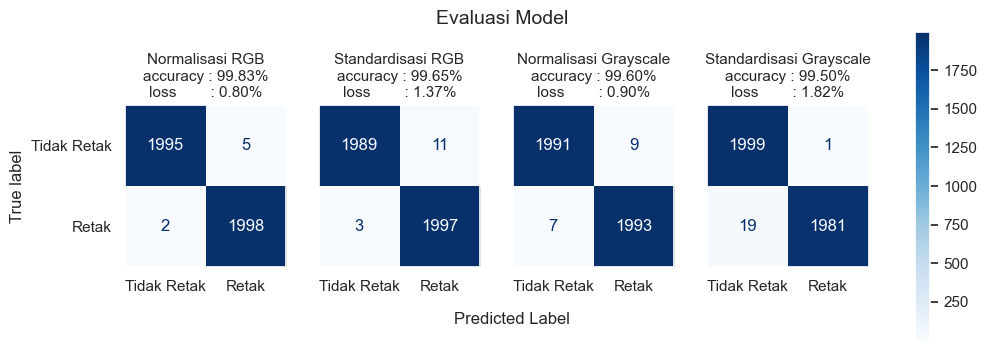

In [281]:
tests = [norm_test_rgb, std_test_rgb, norm_test_gray, std_test_gray]
scores = [score_norm_rgb, score_std_rgb, score_norm_gray, score_std_gray]
prediksi = [prediksi_norm_rgb, prediksi_std_rgb, prediksi_norm_gray, prediksi_std_gray]

f, axes = plt.subplots(1, 4, figsize=(12, 4), sharey="row")

for i in range(4):
    labels = [label for image, label in tests[i].unbatch()]
    
    # Confusion Matrix
    cm = confusion_matrix(labels, prediksi[i])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Tidak Retak", "Retak"]
    )
    
    disp.plot(ax=axes[i], cmap=plt.cm.Blues)
    disp.ax_.set_title(f"{titles[i]}\naccuracy : {scores[i][1]*100:.2f}%\nloss        : {scores[i][0]*100:.2f}%", fontsize=11)
    
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel("")
    if i > 0: disp.ax_.set_ylabel("")
    axes[i].grid(False)
    
f.text(0.4, 0.15, "Predicted Label", ha="left")
f.text(0.385, 0.9, "Evaluasi Model", ha="left", fontsize=14)
f.colorbar(disp.im_, ax=axes)
plt.show()

Jadi, model yang diambil adalah model yang memiliki 
<ul>
    <li> <b>ACCURACY</b> paling tinggi, yakni <b>99.83%</b> </li>
    <li> <b>LOSS</b> paling rendah, yakni <b>0.80%</b> </li>
</ul>
pada model yang menggunakan dataset RGB yang dinormalisasikan.

# 5. Save Model

In [248]:
model = model_norm_rgb

model.save("model.h5")

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)